In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load and normalize data
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [3]:
# Add Gaussian noise
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [4]:
# Define the convolutional autoencoder
def build_autoencoder():
    input_img = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return models.Model(input_img, decoded), models.Model(input_img, encoded)

autoencoder, encoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [5]:
# Train model with EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = autoencoder.fit(x_train_noisy, x_train,
                              epochs=30,
                              batch_size=128,
                              shuffle=True,
                              validation_data=(x_test_noisy, x_test),
                              callbacks=[early_stop])


Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 0.3842 - val_loss: 0.2954
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.2913 - val_loss: 0.2895
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.2867 - val_loss: 0.2869
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.2842 - val_loss: 0.2848
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.2823 - val_loss: 0.2838
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.2815 - val_loss: 0.2824
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.2797 - val_loss: 0.2813
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.2793 - val_loss: 0.2806
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - loss: 0.2785 - val_loss: 0.2799
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.2773 - val_loss: 0.2792
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.2771 - val_loss: 0.2787
Epoch 12/30
469/469 ━━━━━━━━━━

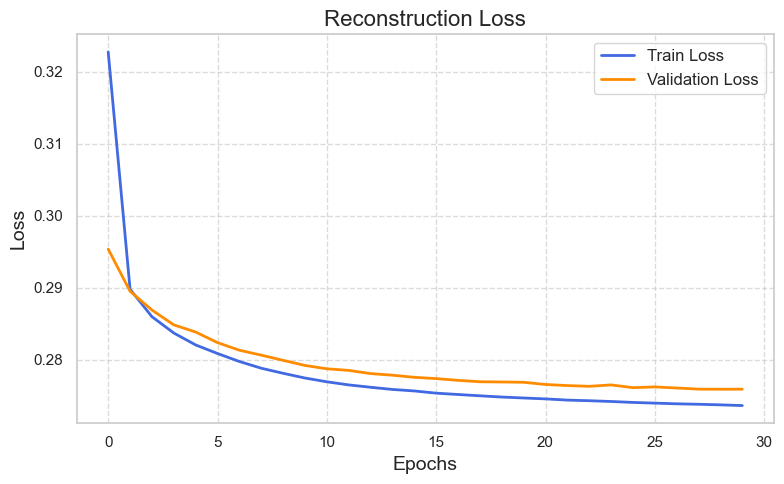

In [6]:
# Plot reconstruction loss with better colors
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss', color='royalblue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange', linewidth=2)
plt.title('Reconstruction Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout() 
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


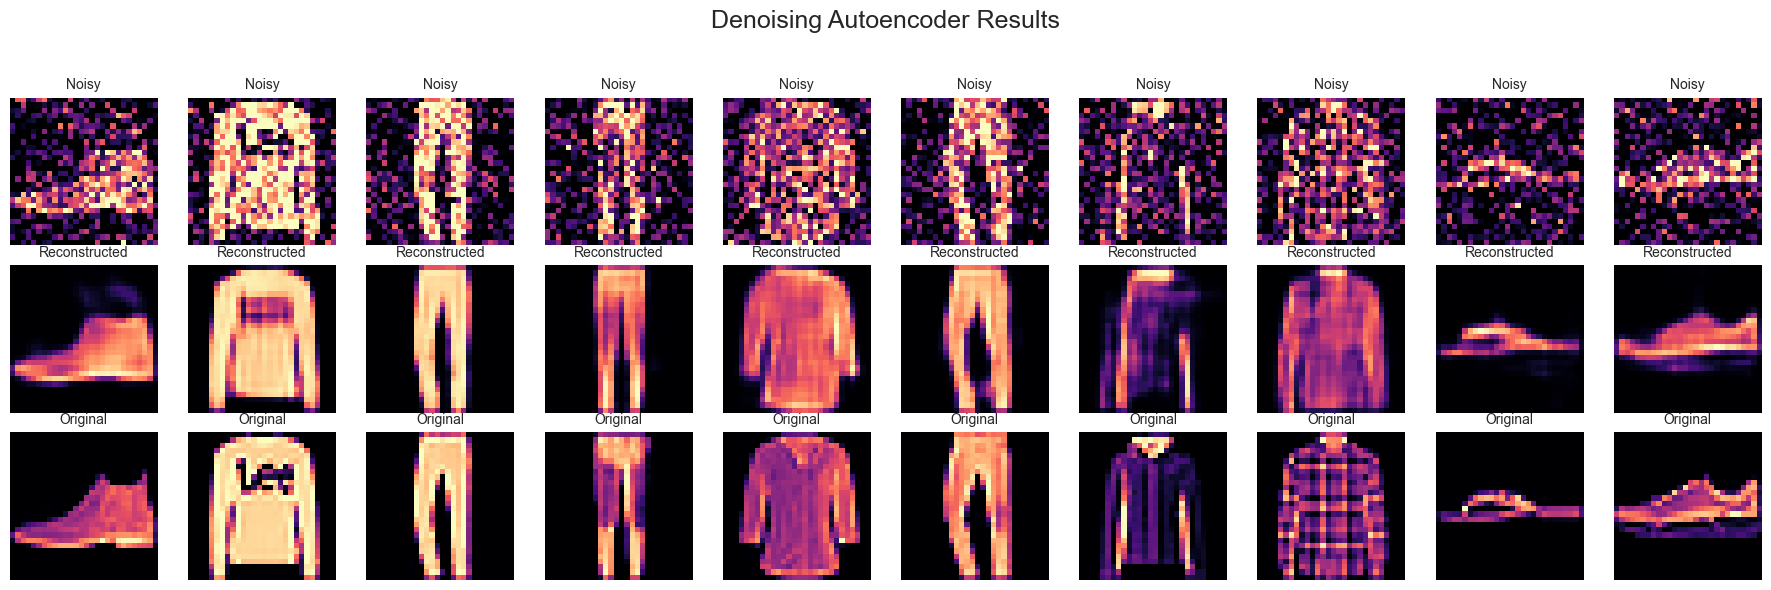

In [7]:
# Visualize original vs noisy vs reconstructed with better colormap
n = 10
decoded_imgs = autoencoder.predict(x_test_noisy[:n])
plt.figure(figsize=(18, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='magma')
    plt.title("Noisy", fontsize=10)
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='magma')
    plt.title("Reconstructed", fontsize=10)
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test[i].squeeze(), cmap='magma')
    plt.title("Original", fontsize=10)
    plt.axis("off")
plt.suptitle('Denoising Autoencoder Results', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


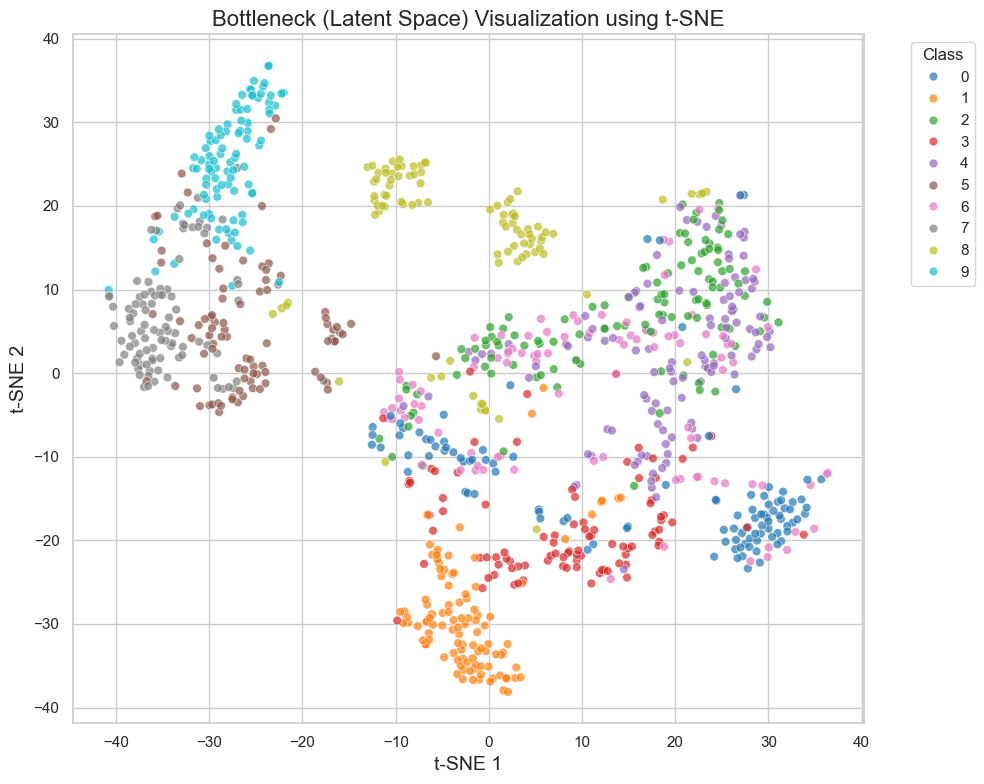

In [8]:
# Bottleneck visualization with t-SNE, colored by class
# For this, we need the labels. Reload with labels:
from keras.datasets import fashion_mnist
(_, y_train), (_, y_test) = fashion_mnist.load_data()
encoded_imgs = encoder.predict(x_test[:1000])
encoded_flat = encoded_imgs.reshape(1000, -1)
from sklearn.manifold import TSNE
import seaborn as sns
sns.set(style="whitegrid")
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(encoded_flat)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=y_test[:1000], palette='tab10', legend='full', s=40, alpha=0.7)
plt.title('Bottleneck (Latent Space) Visualization using t-SNE', fontsize=16)
plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


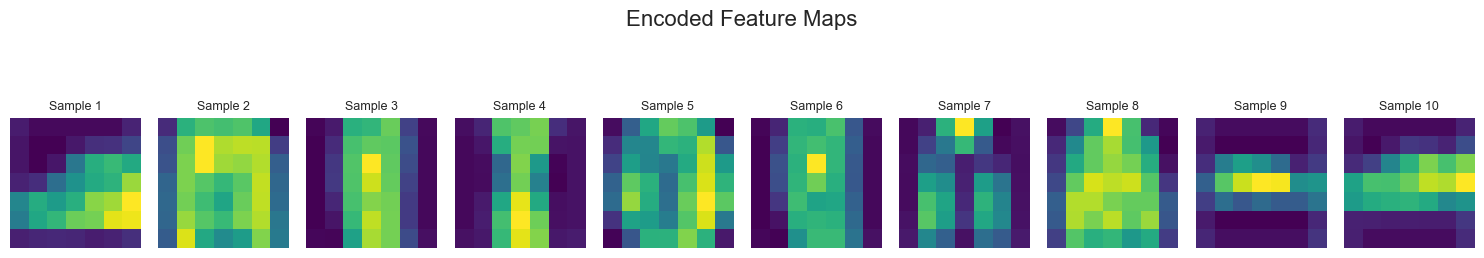

In [9]:
# Visualize encoded (bottleneck) features as images for first 10 test samples
n = 10
encoded_imgs = encoder.predict(x_test[:n])
plt.figure(figsize=(15, 3))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    # Take the encoded feature map and average over channels for visualization
    feature_map = np.mean(encoded_imgs[i], axis=-1)
    plt.imshow(feature_map, cmap='viridis')
    plt.title(f"Sample {i+1}", fontsize=9)
    plt.axis("off")
plt.suptitle('Encoded Feature Maps', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()